1️⃣ Use Hierarchical Forecasting   
  
What It Is   
	•	Hierarchical forecasting aggregates data at higher levels (e.g., brand level or total sales) to compensate for sparsity at lower levels (e.g., brand + family).   
	•	Predictions are made at the higher levels and disaggregated down to smaller groups (e.g., brand-family) using proportions.   
  
Steps to Implement   
	1.	Aggregate to Higher Levels:   
	•	Aggregate sparse brand-family data up to broader levels:   
	•	Brand level: brand_total_sales  
	•	Family level: family_total_sales  
	•	Overall total: global_total_sales  
	•	Use the aggregated time series to train the model.  
	2.	Forecast at Higher Levels:   
	•	Predict sales at the aggregated levels using richer historical data.  
	3.	Disaggregate Forecasts:  
	•	Split the higher-level forecasts back down to the brand-family level using historical proportions. For example:
$\text{brand\_family\_forecast} = \text{brand\_forecast} \times \frac{\text{brand\_family\_sales}}{\text{brand\_total\_sales}}$  
	4.	Smooth Proportions for Stability:  
	•	Use smoothed historical proportions (e.g., rolling averages) to prevent overfitting to noisy historical proportions.  



Steps in the Implementation  
	1.	Aggregate Sparse Data to Higher Levels (e.g., brand).    
	2.	Train a Forecasting Model at the Higher Level (e.g., using a simple statistical model or machine learning).    
	3.	Disaggregate Forecasts:    
	•	Use historical proportions to split higher-level forecasts back down to the brand + family level.  

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Sample data: brand + family level sales
data = {
    "month": pd.date_range(start="2022-01-01", periods=24, freq="M"),
    "brand": ["BrandA", "BrandA", "BrandB", "BrandB"] * 6,
    "family": ["Family1", "Family2", "Family1", "Family2"] * 6,
    "quantity": [100, 50, 200, 150, 110, 55, 210, 160] * 3
}
df = pd.DataFrame(data)

# STEP 1: Aggregate to Higher Levels (e.g., brand level)
df["year_month"] = df["month"].dt.to_period("M")  # Period for monthly data
brand_agg = df.groupby(["year_month", "brand"]).agg({"quantity": "sum"}).reset_index()

# STEP 2: Train Forecasting Model at Higher Level (e.g., brand level)
brand_forecasts = []

for brand, brand_data in brand_agg.groupby("brand"):
    # Sort data for forecasting
    brand_data = brand_data.sort_values("year_month")
    y = brand_data["quantity"].values
    
    # Train an Exponential Smoothing model
    model = ExponentialSmoothing(y, seasonal="add", seasonal_periods=12).fit()
    
    # Forecast for the next 12 months
    future_dates = pd.period_range(start=brand_data["year_month"].max() + 1, periods=12, freq="M")
    forecast = model.forecast(steps=12)
    
    # Collect forecasts
    brand_forecasts.append(pd.DataFrame({
        "year_month": future_dates,
        "brand": brand,
        "quantity_forecast": forecast
    }))

# Combine forecasts for all brands
brand_forecasts = pd.concat(brand_forecasts)

# STEP 3: Disaggregate Forecasts to Brand + Family Level
# Historical proportions of family sales within each brand
df["total_brand_quantity"] = df.groupby(["year_month", "brand"])["quantity"].transform("sum")
df["family_proportion"] = df["quantity"] / df["total_brand_quantity"]

# Average family proportions per brand over time
family_proportions = df.groupby(["brand", "family"]).agg({"family_proportion": "mean"}).reset_index()

# Merge family proportions with brand-level forecasts
disaggregated_forecasts = pd.merge(
    brand_forecasts, family_proportions, on="brand", how="left"
)

# Multiply brand forecasts by family proportions
disaggregated_forecasts["quantity_forecast"] = (
    disaggregated_forecasts["quantity_forecast"] * disaggregated_forecasts["family_proportion"]
)

# Final disaggregated forecasts
final_forecasts = disaggregated_forecasts[["year_month", "brand", "family", "quantity_forecast"]]
final_forecasts["quantity_forecast"] = final_forecasts["quantity_forecast"].round(2)

# Print results
print(final_forecasts)

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_17686/513237797.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "month": pd.date_range(start="2022-01-01", periods=24, freq="M"),


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:

# Step 1: Load and Aggregate Data
def load_and_aggregate_data():
    # Load data
    df_sales = pd.read_parquet("data/sales.parquet")
    df_products = pd.read_parquet("data/products.parquet")
    data = df_sales.merge(df_products, on="product_id")
    data = data.rename(columns={"fecha": "date"})
    
    # Convert 'date' to datetime and extract month
    data['date'] = pd.to_datetime(data['date'])
    data['year_month'] = data['date'].dt.to_period('M')
    
    # Aggregate to monthly revenue
    data['revenue'] = data['quantity'] * data['pvp']
    monthly_data = data.groupby(['brand', 'family', 'year_month'], as_index=False).agg({
        'revenue': 'sum',
        # 'quantity': 'sum',
        # 'pvp': 'mean'  # Average price
    })
    return monthly_data

# Step 2: Feature Engineering
def add_features(data):
    # Temporal Features
    data['month'] = data['year_month'].dt.month
    data['year'] = data['year_month'].dt.year

    # Decompose 'family' into type and category
    data[['clothing_type', 'clothing_category']] = data['family'].str.split(' ', n=1, expand=True)

    # Lag Features
    data = data.sort_values(['brand', 'family', 'year_month'])
    data['lag_12'] = data.groupby(['brand', 'family'])['revenue'].shift(12)

    # Rolling Features
    data[f"rolling_mean_3"] = data.groupby(['brand', 'family'], observed=False)[
            'revenue'
        ].transform(lambda x: x.shift(13).rolling(3, min_periods=1).mean())
    data[f"rolling_std_3"] = data.groupby(['brand', 'family'], observed=False)[
            'revenue'
        ].transform(lambda x: x.shift(13).rolling(3, min_periods=1).mean())
    
    return data

# Step 3: Handle Missing Lag-12 Data
def handle_missing_data(data):
    # Replace missing values with overall means grouped by brand or family
    data['lag_12'] = data['lag_12'].fillna(data.groupby(['brand', 'family'])['revenue'].transform('mean'))
    data['rolling_mean_3'] = data['rolling_mean_3'].fillna(data.groupby(['brand', 'family'])['revenue'].transform('mean'))
    data['rolling_std_3'] = data['rolling_std_3'].fillna(0)  # Fill std with 0 if no rolling window exists

    return data

# Step 4: Train-Test Split
def train_test_split_data(data):
    features = ['month', 'lag_12', 'rolling_mean_3', 'rolling_std_3', 'pvp']
    target = 'revenue'

    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    return X_train, X_test, y_train, y_test

# Step 5: Forecasting with Gradient Boosting
def train_forecasting_model(X_train, y_train):
    model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    return model

# Step 6: Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.reset_index(drop=True), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.title("Actual vs Predicted Revenue")
    plt.show()

# # Step 7: Main Workflow
# def main(file_path):
#     # Load and preprocess data
#     monthly_data = load_and_aggregate_data(file_path)
    
#     # Add features
#     monthly_data = add_features(monthly_data)

#     # Handle missing data
#     monthly_data = handle_missing_data(monthly_data)

#     # Split data into train and test
#     X_train, X_test, y_train, y_test = train_test_split_data(monthly_data)

#     # Train forecasting model
#     model = train_forecasting_model(X_train, y_train)

#     # Evaluate the model
#     evaluate_model(model, X_test, y_test)


In [34]:
monthly_data = load_and_aggregate_data()
monthly_data = add_features(monthly_data)
monthly_data = handle_missing_data(monthly_data)

MAE: 1807.11
RMSE: 4094.25


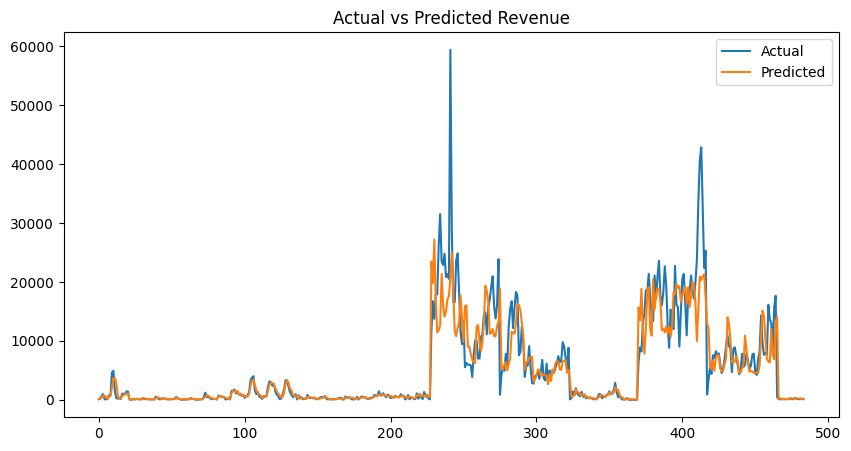

In [16]:
X_train, X_test, y_train, y_test = train_test_split_data(monthly_data)
model = train_forecasting_model(X_train, y_train)
evaluate_model(model, X_test, y_test)

In [22]:
monthly_data

,brand,family,year_month,revenue,quantity,pvp,month,year,clothing_type,clothing_category,lag_12,rolling_mean_3,rolling_std_3
0,Columbia,Bañadores Natación,2021-09,99.95,1.0,99.950000,9,2021,Bañadores,Natación,139.975000,139.975000,0.000000
1,Columbia,Bañadores Natación,2024-07,180.00,1.0,180.000000,7,2024,Bañadores,Natación,139.975000,139.975000,0.000000
2,Columbia,Botas Urban,2023-12,260.00,2.0,130.000000,12,2023,Botas,Urban,260.000000,260.000000,0.000000
3,Columbia,Botas Urban,2024-01,260.00,2.0,130.000000,1,2024,Botas,Urban,260.000000,260.000000,0.000000
4,Columbia,Botas de montaña,2020-09,819.85,13.0,63.065385,9,2020,Botas,de montaña,2289.048085,2289.048085,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524,adidas,Zuecos Urban,2023-09,99.95,1.0,99.950000,9,2023,Zuecos,Urban,99.950000,299.965000,299.965000
2525,adidas,Zuecos Urban,2023-11,99.95,1.0,99.950000,11,2023,Zuecos,Urban,99.950000,233.293333,233.293333
2526,adidas,Zuecos Urban,2024-05,199.90,2.0,99.950000,5,2024,Zuecos,Urban,99.950000,99.950000,99.950000
2527,adidas,Zuecos Urban,2024-06,99.95,1.0,99.950000,6,2024,Zuecos,Urban,99.950000,99.950000,99.950000


In [30]:
monthly_data[(monthly_data["family"] == "Camisetas Urban") & (monthly_data["brand"] == "adidas")]

,brand,family,year_month,revenue,quantity,pvp,month,year,clothing_type,clothing_category,lag_12,rolling_mean_3,rolling_std_3
1077,adidas,Camisetas Urban,2020-09,579.80,13.0,44.600000,9,2020,Camisetas,Urban,NaN,NaN,NaN
1078,adidas,Camisetas Urban,2020-10,259.95,6.0,43.325000,10,2020,Camisetas,Urban,NaN,NaN,NaN
1079,adidas,Camisetas Urban,2020-11,420.00,8.0,52.500000,11,2020,Camisetas,Urban,NaN,NaN,NaN
1080,adidas,Camisetas Urban,2020-12,750.75,15.0,50.050000,12,2020,Camisetas,Urban,NaN,NaN,NaN
1081,adidas,Camisetas Urban,2021-01,837.70,20.0,41.885000,1,2021,Camisetas,Urban,NaN,NaN,NaN
1082,adidas,Camisetas Urban,2021-02,1162.55,31.0,37.501613,2,2021,Camisetas,Urban,NaN,NaN,NaN
1083,adidas,Camisetas Urban,2021-03,967.85,21.0,46.088095,3,2021,Camisetas,Urban,NaN,NaN,NaN
1084,adidas,Camisetas Urban,2021-04,1153.90,25.0,46.156000,4,2021,Camisetas,Urban,NaN,NaN,NaN
1085,adidas,Camisetas Urban,2021-05,354.90,8.0,44.362500,5,2021,Camisetas,Urban,NaN,NaN,NaN
1086,adidas,Camisetas Urban,2021-06,308.00,5.0,61.600000,6,2021,Camisetas,Urban,NaN,NaN,NaN


In [26]:
monthly_data[(monthly_data["family"] == "Camisetas Urban") & (monthly_data["brand"] == "adidas")]['revenue'].mean()

np.float64(1112.9669387755102)

<Axes: xlabel='year_month'>

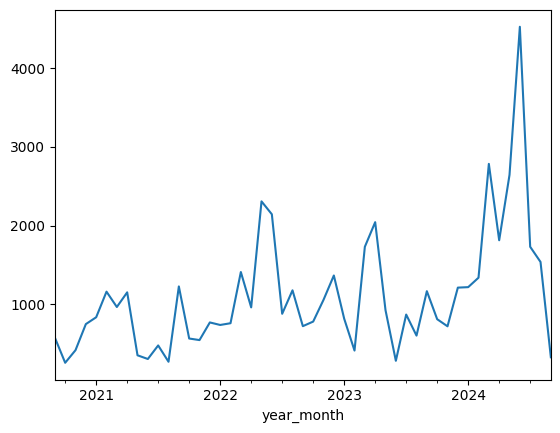

In [33]:
monthly_data[(monthly_data["family"] == "Camisetas Urban") & (monthly_data["brand"] == "adidas")].set_index('year_month').sort_index()['revenue'].plot()

<Axes: xlabel='year_month'>

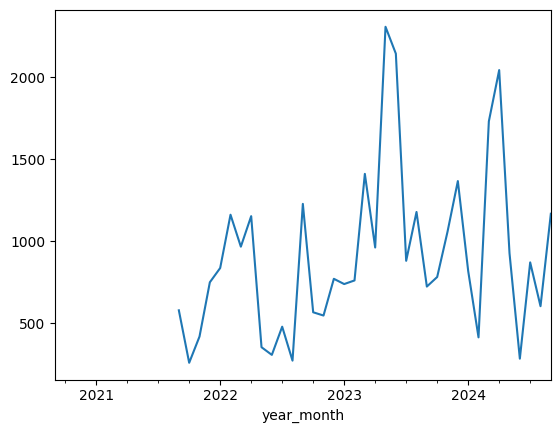

In [32]:
monthly_data[(monthly_data["family"] == "Camisetas Urban") & (monthly_data["brand"] == "adidas")].set_index('year_month').sort_index()['lag_12'].plot()

<Axes: xlabel='year_month'>

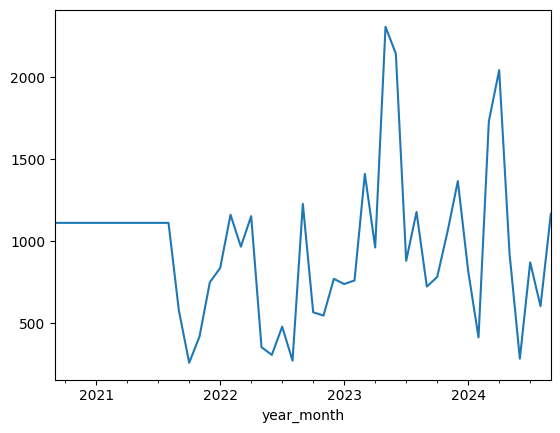

In [35]:
monthly_data[(monthly_data["family"] == "Camisetas Urban") & (monthly_data["brand"] == "adidas")].set_index('year_month').sort_index()['lag_12'].plot()

In [3]:
# Example DataFrame
data = {'sku': [1, 1, 2, 2, 3], 'value': [10, 20, 30, 40, 50]}
X = pd.DataFrame(data)

# Group by 'sku' and get the last value in 'value'
last_values_per_sku = X.sort_index().groupby('sku')['value'].last().to_dict()

# Map the dictionary to the 'sku' column
result = X['sku'].map(last_values_per_sku).fillna(0)

print(result.values)

[20 20 40 40 50]
